## Теория вероятностей и математическая статистика
### ANOVA: однофакторный дисперсионный анализ 

*Алла Тамбовцева*

Импортируем необходимые библиотеки, модули и функции:

* библиотеку `pandas` для обработки данных;
* модуль `api` из библиотеки `statsmodels` для запуска статистических функций;
* функцию `ols()` для оценки линейной модели (нужна для ANOVA).

In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

### Часть 1: данные по городам

Загрузим данные из файла `cities.csv` и посмотрим на первые 5 строк датафрейма:

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/allatambov/StatCS25/refs/heads/main/cities.csv")
print(df.head())

   Unnamed: 0   city  height
0           0  Сиэтл     943
1           1  Сиэтл     740
2           2  Сиэтл     735
3           3  Сиэтл     722
4           4  Сиэтл     609


Для базового примера были взяты небольшие учебные данные из задачника, работа с которыми подробно разбирается в главе про ANOVA, чтобы можно было убедиться, что Python выполняет ровно те же действия при реализации однофакторного анализа, что и задумано по классическому алгоритму (без поправок и дополнений). 

В датафрейме `df` сохранены значения высоты домов в футах в четырех городах: Сиэтл, Монреаль, Новый Орлеан, Питсбург. Задача – сравнить среднюю высоту домов в этих городах на основе выборок значений. Начнем с описательных статистик. Сгруппируем строки по городу (столбец `city`) и выведем описательные статисики для высоты (столбец `height`):

In [4]:
print(df.groupby("city")["height"].describe())

              count   mean         std    min    25%    50%     75%    max
city                                                                      
Монреаль       17.0  509.0   96.171721  355.0  443.0  479.0  612.00  669.0
Новый Орлеан   10.0  510.0   94.196013  406.0  445.5  479.5  530.75  697.0
Питсбург       15.0  539.0  126.971313  420.0  436.0  485.0  615.50  841.0
Сиэтл          23.0  550.0  143.615332  193.0  483.5  520.0  592.50  943.0


Что мы видим? Во-первых, выборки не очень большие, все менее 30 наблюдений. Но пример учебный, изначально рассчитанный на вычисления руками, поэтому все в порядке. Во-вторых, нельзя сказать, что средние по группам очень сильно отличаются друг от друга. Формально отличия есть, но стандартные отклонения по каждой группе довольно большие, вряд ли в совокупности разброс значений высоты будет настолько маленьким, что небольшие значения разностей средних можно будет счесть значительными.

Также отметим, что распределение `height` во всех группах не совсем симметрично, немного скошено вправо – среднее в каждой группе превышает медиану (на 30 и более футов). Убедимся в этом, построив гистограммы и ящики с усами по группам:

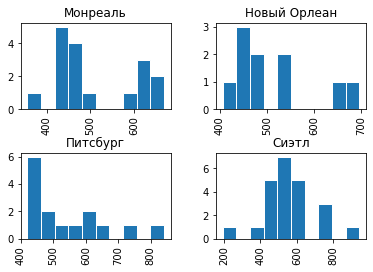

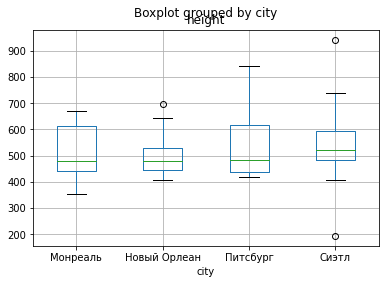

In [5]:
df.hist("height", by = "city", edgecolor = "white");
df.boxplot("height", by = "city");

Так и есть, действительно, распределение высоты домов в каждом городе скошено вправо, в выборках для Нового Орлеана и Сиэтла даже встречаются нехарактерные значения. Означает ли это, что для дальнейшего сравнения средних ANOVA с предположением нормальности распределения в каждой группе не применима? Нет, поскольку на практике это требование часто ослабляется, если нет серьезных оснований считать, что распределение теоретически нормальным быть не может (дискретные данные, скошенность из-за характера данных). В данном случае нельзя категорично сказать, что распределение высоты домов в крупных городах с разнообразной застройкой нормальным быть не может, плюс, выборки достаточно маленькими, скошенность может возникать из-за небольшого числа наблюдений.

Поэтому отметим, что медианные высоты по группам тоже очень близки и перейдем к проверке гипотез. Итак:

$$
H_0: a_1  = a_2 = a_3 = a_4 = a 
$$
$$
H_1: \exists j \text{ } a_j \ne a
$$

В Python в модуле `stats` библиотеки `scipy` есть функция `f_oneway()` для реализации ANOVA, однако эта функция выдает только наблюдаемое значение F-статистики и p-value, без подробной таблицы с разложением вариации. Поэтому пойдем по более длинному пути – построим линейную регрессионную модель, где зависимой переменной является `height`, а независимой – `city`, а затем запросим для результатов оценки такой модели ANOVA-таблицу:

In [6]:
# ols() – ordinary least squares, метод наименьших квадратов
# fit() – оценка модели
# anova_lm() – таблица ANOVA на основе линейной модели

mod = ols('height ~ city', data = df).fit()
tab = sm.stats.anova_lm(mod)
print(tab)

            df         sum_sq       mean_sq         F    PR(>F)
city       3.0   21889.784615   7296.594872  0.490567  0.690129
Residual  61.0  907302.000000  14873.803279       NaN       NaN


Строка `city` здесь отвечает за показатели, посчитанные для межгрупповых различий, то есть за описание той части дисперсии данных, которую можно объяснить делением на группы. Так как именно обоснованность такого деления мы и пытаемся проверить с помощью модели, `sum_sq` в этой строке – и есть $MSS$ (*model sum of squares*) или $SS_{between}$ (*sum of squares between groups*).

Строка `residual` отвечает за показатели, посчитанные для внутригрупповых различий, то есть за описание той части дисперсии данных, которая не объясняется делением на группы, а значит, не объясняется моделью. Отсюда и название – остаточная сумма квадратов, `sum_sq` в этой строке – $RSS$ (*residual sum of squares*) или $SS_{within}$ (*sum of squares within groups*).

В столбце `df` сохранены значения числа степеней свободы. В первом случае $\text{df} = k-1$, где $k$ – число групп, поэтому здесь 3. Во втором случае $\text{df} = n-k$, где $n$ – число наблюдений, в данном датафрейме 65 строк, поэтому здесь 61.

В столбце `mean_sq` сохранены средние суммы квадратов отклонений от среднего:

* *Mean MSS* или $MS_{between} = \frac{21889.78}{3} = 7296.59$
* *Mean RSS* или $MS_{within} = \frac{907302}{61} = 14873.80$.

Чтобы проверить, можно ли считать, что разнообразие значений высоты в четырех разных городах действительно объясняется делением на четыре группы, сравним оценки межгрупповой дисперсии и внутригрупповой – вычислим наблюдаемое значение F-статистики:

$$
F = \frac{7296.59}{14873.80} = 0.49
$$

Значение довольно маленькое, меньше 1, а значит, нельзя сказать, что межгрупповая дисперсия выше. Посмотрим на `p-value`, которое в таблице обозначено как `PR(>F)`. Итого:

$$
\text{pvalue} = \text{P}(F > 0.49) = 0.69
$$

Очень большое значение, на любом разумном уровне значимости (1\%, 5\%, 10\%) нулевая гипотеза не отвергается. Следовательно, среднюю высотов домов в четырех городах можно считать равной.

**Дополнение.** В ANOVA-таблице выше есть значения `NaN`, это нормально. Так как по логике статистического критерия именно оценку межгрупповой дисперсии нужно делить на оценку внутригрупповой дисперсии, а не наоборот, другое значение `F` невозможно (и `p-value`, соответственно, тоже).

Давайте немного доработаем таблицу выше и добавим в неё общую сумму квадратов $TSS$ (*total sum of squares*). Для этого просто выберем и сложим $MSS$ и $RSS$ из таблицы:

In [7]:
MSS = tab["sum_sq"][0]
RSS = tab["sum_sq"][1]
TSS = MSS + RSS
print(TSS)

929191.7846153844


Чтобы к ANOVA-таблице `tab` выше добавить строку со всем необходимым для оценки общей дисперсии, зафиксируем число наблюдений, которое понадобится нам для вычисления *Mean TSS*. 

In [8]:
# число строк, внутри shape – пара 
# число строк-число столбцов

n = df.shape[0]
print(n)

65


Сформируем строку для добавления к `tab` – это будет маленький датафрейм из единственной строки с TSS. Создадим датафрейм на основе списка словарей, один словарь в списке соответствует одной строке:

In [9]:
row = pd.DataFrame([{"df" : n - 1, 
                    "sum_sq" : TSS, 
                    "mean_sq" : TSS / (n - 1)}])
row

,df,sum_sq,mean_sq
0,64,929191.784615,14518.621635


Готово! Склеиваем `tab` и `row` по строкам через функцию `concat()` и меняем названия строк в `.index` на более привычные:

In [10]:
fin = pd.concat([tab, row])
fin.index = ["MSS", "RSS", "TSS"]
fin

,df,sum_sq,mean_sq,F,PR(>F)
MSS,3.0,21889.784615,7296.594872,0.490567,0.690129
RSS,61.0,907302.000000,14873.803279,NaN,NaN
TSS,64.0,929191.784615,14518.621635,NaN,NaN


Используя таблицу выше, можем вычислить долю дисперсии, объясненной моделью, то есть долю изменчивости данных, которую можно объяснить делением на группы. Другими словами, вычислить $R^2$ (еще называют коэффициентом детерминации):

$$
R^2 = \frac{MSS}{TSS}
$$

In [11]:
print(fin.loc["MSS", "sum_sq"] / fin.loc["TSS", "sum_sq"])

0.02355787575591331


Значение очень низкое, что неудивительно – мы уже выяснили, что различий в средних по группам нет, а значит, модель, описывающая различия делением на группы, не самая удачная с точки зрения объясняющей силы.

Полная ANOVA-таблица готова, при желании ее можно выгрузить в любой формат – в LaTeX, Markdown, HTML и прочие:

In [12]:
print(fin.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &    df &         sum\_sq &       mean\_sq &         F &    PR(>F) \\
\midrule
MSS &   3.0 &   21889.784615 &   7296.594872 &  0.490567 &  0.690129 \\
RSS &  61.0 &  907302.000000 &  14873.803279 &       NaN &       NaN \\
TSS &  64.0 &  929191.784615 &  14518.621635 &       NaN &       NaN \\
\bottomrule
\end{tabular}



In [13]:
print(fin.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>df</th>
      <th>sum_sq</th>
      <th>mean_sq</th>
      <th>F</th>
      <th>PR(&gt;F)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>MSS</th>
      <td>3.0</td>
      <td>21889.784615</td>
      <td>7296.594872</td>
      <td>0.490567</td>
      <td>0.690129</td>
    </tr>
    <tr>
      <th>RSS</th>
      <td>61.0</td>
      <td>907302.000000</td>
      <td>14873.803279</td>
      <td>NaN</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>TSS</th>
      <td>64.0</td>
      <td>929191.784615</td>
      <td>14518.621635</td>
      <td>NaN</td>
      <td>NaN</td>
    </tr>
  </tbody>
</table>


### Часть 2: данные по диетам

В файле `Diets.csv` хранятся результаты обследования участников эксперимента, которые следовали разным типам диеты. Переменные в файле:

* `Person`: id участника;
* `gender`: пол участника (0 – женский, 1 – мужской);
* `Age`: возраст участника;
* `Height`: рост участника (в см);
* `pre.weight`: вес участника на начало эксперимента (в кг);
* `weight6week`: вес участника на конец эксперимента (в кг).
* `Diet`: тип диеты (1, 2, 3);
* `Diff`: разница в весе до диеты и после, количество сброшенных килограммов после 6 недель диеты.

Загрузим данные и посмотрим на первые 5 строк таблицы:

In [14]:
diets = pd.read_csv("https://raw.githubusercontent.com/allatambov/StatCS25/refs/heads/main/Diets.csv")
print(diets.head())

   Unnamed: 0  Person  gender  Age  Height  pre.weight  Diet  weight6weeks  \
0           0      25     NaN   41     171          60     2          60.0   
1           1      26     NaN   32     174         103     2         103.0   
2           2       1     0.0   22     159          58     1          54.2   
3           3       2     0.0   46     192          60     1          54.0   
4           4       3     0.0   55     170          64     1          63.3   

   Diff  
0   0.0  
1   0.0  
2   3.8  
3   6.0  
4   0.7  


Чтобы сравнить эффективность диет, определяемую через снижение веса, логично будет сравнить среднюю потерю веса в трех группах (диета 1, диета 2, диета 3). Для начала выведем описательные статистики по группам:

In [15]:
# группируем по Diet, для Diff из результатов .describe()
# забираем count, mean, std

diets.groupby("Diet")["Diff"].describe()[["count", "mean", "std"]]

,count,mean,std
Diet,,,
1,24.0,3.300000,2.240148
2,27.0,3.025926,2.523367
3,27.0,5.148148,2.395568


Группы участников в этот раз тоже не очень большие, но некритично. Среднее число килограммов, которые были потеряны в течение следования первым двум диетам, отличается несильно (3.3 vs 3.03), а вот среднее число килограммов, потерянных при следовании третьей диете явно выше (5.15). Есть основания ожидать, что не все средние значения `Diff` по группам равны. Приступим к проверке гипотез с помощью ANOVA:

$$
H_0: a_1 = a_2 = a_3 = a
$$
$$
H_1: \exists j \text{ } a_j \ne a
$$

Прежде, чем это сделать, учтем один важный нюанс. В данном случае название групп – не текстовое (например, диеты A, B, C), а числовое (целые числа 1, 2, 3). Так как для получения ANOVA-таблицы мы предварительно строим линейную регрессионную модель, включать в нее тип диеты в виде числа некорректно. Модель будет оцениваться в предположении, что обе переменных – в количественной шкале, и базироваться на корреляции между потерей веса и порядковым номером диеты, которая здесь содержательно не имеет смысла.

Чтобы не изменять сам столбец `Diet`, в уравнении внутри `ols()` вокруг `Diet` добавим функцию `C()`, в `statsmodels` это означает, что переменная категориальная (*categorical*), то есть качественная:

In [16]:
model_d = ols('Diff ~ C(Diet)', data = diets).fit()
anova = sm.stats.anova_lm(model_d)
print(anova)

            df      sum_sq    mean_sq         F    PR(>F)
C(Diet)    2.0   71.093689  35.546845  6.197447  0.003229
Residual  75.0  430.179259   5.735723       NaN       NaN


Так как подробно устройство таблицы уже обсуждали выше, сфокусируемся на последних двух столбцах. Наблюдаемое значение F-статистики достаточно высокое, а p-value – низкое. На любом разумном уровне значимости (1%, 5%, 10%) нулевую гипотезу необходимо отвергнуть. Не все средние равны, диеты отличаются по эффективности, если эффективнось определять как среднюю потерю веса в течение следования диете.

К слову, значение $R^2$ можно вычислить и без манипуляций с TSS, его можно вызвать из самой модели `model_d`, без ANOVA-таблицы (о же будет актуально потом для регрессий):

In [17]:
# модель объясняет 14% вариации данных, маловато

print(model_d.rsquared)

0.14182630369446003


Остановимся на средних поподробнее. Построим для среднего значения `Diff` по каждой группе 95%-ный доверительный интервал. Но сначала отфильтуем данные – сформируем три набора значений потери веса `Diff`:

In [18]:
# отбираем строки для каждого типа диеты
# забираем значения из столбца Diff

one = diets[diets["Diet"] == 1]["Diff"]
two = diets[diets["Diet"] == 2]["Diff"]
three = diets[diets["Diet"] == 3]["Diff"]

# один набор данных – pandas Series,
# массив значений + индексы

print(one.head()) 

2    3.8
3    6.0
4    0.7
5    2.9
6    2.8
Name: Diff, dtype: float64


Импортируем модуль `stats` из библиотеки `scipy` и воспользуемся некоторыми функциями:
* функция `t.interval()` – для построения симметричного интервала на основе распределения Стьюдента;
* функция `sem()` – для вычисления стандартной ошибки среднего ($SE = \frac{s}{\sqrt{n}}$).

In [19]:
from scipy import stats

# loc – середина интервала, само значение оценки (среднее выборки)
# scale – разброс, стандартное отклонение оценки (стандартная ошибка среднего)
# на первом месте указываем уровень доверия
# в df фиксируем число степеней свободы df = n - 1

print(stats.t.interval(0.95, loc = one.mean(), 
                       scale = stats.sem(one), 
                       df = one.size - 1))
print(stats.t.interval(0.95, loc = two.mean(), 
                       scale = stats.sem(two),
                       df = two.size - 1))
print(stats.t.interval(0.95, 
                       loc = three.mean(), 
                       scale = stats.sem(three), 
                       df = three.size - 1))

(2.3540686667368274, 4.245931333263171)
(2.0277153508690646, 4.024136500982788)
(4.200492976467615, 6.095803319828679)


В итоге мы получили три 95%-ных доверительных интервала для средней потери веса при следовании разным диетам. Последний интервал сильно отличается от первых двух, он точно с ними не пересекается. Это означает, что на 95%-ном уровне доверия можно считать, что третья диета, в среднем, более эффективна, чем первые две. Насчет первых двух диет – не совсем понятно. Доверительные интервалы пересекаются, но сделать из этого вывод, что первые два средних неотличимы при таком уровне доверия, нельзя, надо оценить «масштабы» пересечения. На практике величину пересечений не оценивают, просто переходят от доверительных интервалов к проверке гипотез. 

Сравним средние в первых двух группах, используя двухвыборочный критерий Стьюдента:

$$
H_0: a_1 = a_2 \text{ против } H_1: a_1 \ne a_2
$$

In [20]:
print(stats.ttest_ind(one, two))

Ttest_indResult(statistic=0.40797824323257154, pvalue=0.6850668861405854)


Наблюдаемое значение статистики близко к 0, p-value примерно 0.69. Нулевая гипотеза на любом разумном уровне значимости не отвергается, средние можно считать равными.

Проделаем заодно подобную операцию с другими парами групп (здесь всего три пары, 1 и 2, 2 и 3, 1 и 3):

In [21]:
print(stats.ttest_ind(two, three))
print(stats.ttest_ind(one, three))

Ttest_indResult(statistic=-3.1693496673045676, pvalue=0.0025599026452984013)
Ttest_indResult(statistic=-2.834783037306771, pvalue=0.006644381649741192)


В обоих случаях p-value мало, гипотеза о равенстве средних отвергается, значит, средняя эффективность диет 2 и 3, диет 1 и 3 отличается. Остается любопытный вопрос: а можно ли заменить ANOVA множественным сравнением средних, то есть просто серией t-тестов для всех пар групп? 

Ответ: без дополнительных корректировок нежелательно, поскольку в серии множественных сравнений возрастает значение ошибки первого рода для всей серии. Чтобы снизить риск такой ошибки, можно провести серию попарных t-тестов, а затем сравнивать p-value не с уровнем значимости $\alpha$, а с $\alpha/k$, где $k$ – число сравнений (число проверяемых гипотез). 

Так, в нашем примере, если мы выберем уровень значимости $\alpha = 0.05$, сравнивать p-value в выдачах выше нужно будет с $0.05/3\approx 0.017$. Такая корректировка является очень популярной и называется **поправкой Бонферрони** (*Bonferroni correction*). Про проблему множественных сравнений обзорно можно почитать [здесь](https://en.wikipedia.org/wiki/Multiple_comparisons_problem).

**NB.** В ANOVA никаких поправок не делаем, сравниваем p-value с обычным уровнем значимости $\alpha$, там нет множественных сравнений, оцениваем отношение межгрупповой и внутригрупповой дисперсий.